In [1]:
### 기본적으로, 파이썬의 예외는 try-except 구문으로 처리할 수 있는 고수준 예외에 대한 정보를 제공
###   그러나 세그멘테이션 오류와 같은 낮은 수준의 문제는 일반적인 예외 처리로는 잡히지 않는데, 이때 faulthandler가 사용

##  여기선 pyspark 가 사용하는 JVM 때문에 문제가 생기거나 메모리 관리 등으로 생긴 문제를 추적하는데 쓸 듯?

import faulthandler

faulthandler.enable()                             # 1. faulthandler를 활성화하여 오류가 발생할 때 스택 트레이스를 자동으로 출력하도록 설정

In [2]:
# import findspark
# import os

# findspark.init(os.environ.get("SPARK_HOME"))      # Spark를 설치하고 환경 변수를 올바르게 설정하는 것이 복잡할 수 있는데, findspark는 이러한 과정들을 자동화


from pyspark.sql import SparkSession 

# from pyspark import SparkContext
# sc = SparkContext("local", "Python Spark SQL Practice")   # Spark 애플리케이션의 진입점 역할을 하는 객체
# print("스파크 컨텍스트 버젼: ", sc.version)
# print("Spark Context 파이썬 버전:", sc.pythonVer)
# print("Spark Context 마스터:", sc.master)


# Pyspark는 SparkSession이 SparkContext 포함, SparkSession이 내부적으로 SparkContext를 생성하여 사용
#  데이터프레임 API를 사용하거나 SQL 작업을 할 때 주로 사용

spark = SparkSession.builder.master('local').appName('Python Spark SQL Practice').getOrCreate()
                                    # 로컬환경                내가 정한 이름

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import ArrayType, DoubleType, BooleanType, DateType, FloatType, TimestampType
from pyspark.sql.functions import col, array_contains, isnan, when, count
from pyspark.sql.functions import lit, concat_ws, concat, collect_list, udf
from pyspark.sql.functions import countDistinct

In [4]:
file_path = 'D:/workspace/data/2019-Oct.csv'
df = spark.read.csv(file_path, header=True)

In [5]:
df.show()

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:...|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:...|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|  33.20|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:...|      view|  17200506|2053013559792632471|furniture.living_...|    NULL| 543.10|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:...|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:...|      view|   1004237|205301355563188265

In [6]:
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [7]:
df.dtypes

[('event_time', 'string'),
 ('event_type', 'string'),
 ('product_id', 'string'),
 ('category_id', 'string'),
 ('category_code', 'string'),
 ('brand', 'string'),
 ('price', 'string'),
 ('user_id', 'string'),
 ('user_session', 'string')]

In [8]:
schema = StructType() \
      .add("event_time",TimestampType(),True) \
      .add("event_type",StringType(),True) \
      .add("product_id",StringType(),True) \
      .add("category_id",StringType(),True) \
      .add("category_code",StringType(),True) \
      .add("brand",StringType(),True) \
      .add("price",DoubleType(),True) \
      .add("user_id",StringType(),True) \
      .add("user_session",StringType(),True) 

In [9]:
df = spark.read.schema(schema).csv(file_path, header=True)

In [10]:
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [11]:
df.createOrReplaceTempView('ecommerce')

spark.sql("SELECT * FROM ecommerce").show()

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 09:00:00|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 09:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 09:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    NULL|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 09:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 09:00:04|      view|   1004237|2053013555631882655|electr

In [13]:
spark.sql("SELECT event_type, count(*) AS count FROM ecommerce GROUP BY event_type").show()

+----------+--------+
|event_type|   count|
+----------+--------+
|  purchase|  742849|
|      view|40779399|
|      cart|  926516|
+----------+--------+



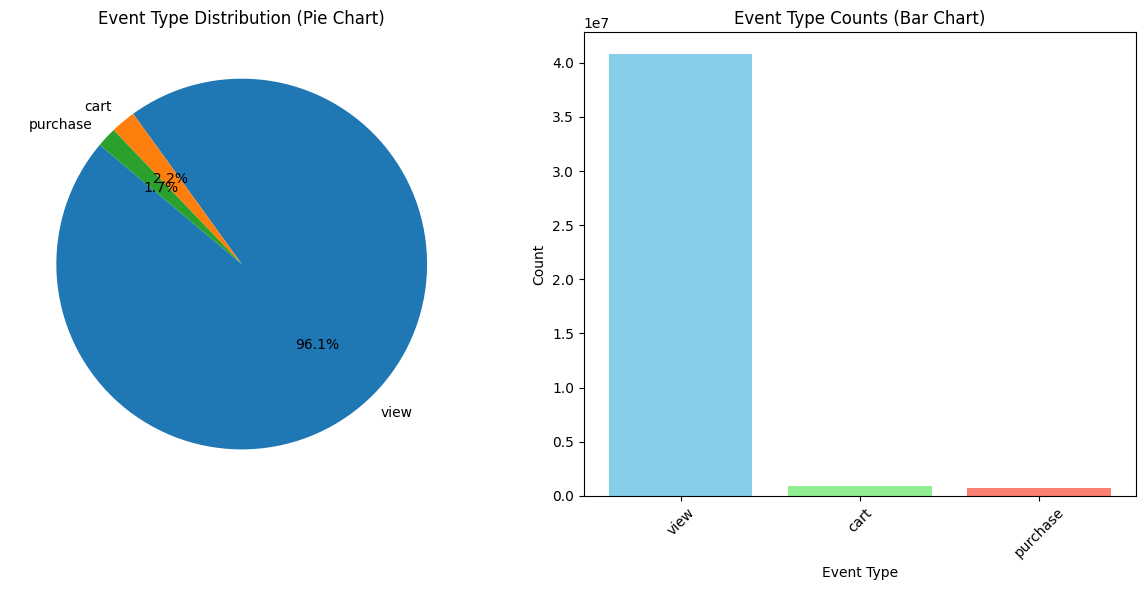

In [14]:
import matplotlib.pyplot as plt

# Spark SQL 쿼리 결과를 Spark DataFrame으로 가져오기
result_df = spark.sql("SELECT event_type, count(*) AS count FROM ecommerce GROUP BY event_type")

# Spark DataFrame을 Pandas DataFrame으로 변환
pandas_df = result_df.toPandas()

# 이벤트 타입을 view -> cart -> purchase 순으로 정렬
pandas_df = pandas_df.set_index('event_type').reindex(['view', 'cart', 'purchase']).reset_index()

# 원 그래프 생성
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 첫 번째 그래프는 원 그래프
plt.pie(pandas_df['count'], labels=pandas_df['event_type'], autopct='%1.1f%%', startangle=140)
plt.title('Event Type Distribution (Pie Chart)')

# 막대 그래프 생성
plt.subplot(1, 2, 2)  # 두 번째 그래프는 막대 그래프
plt.bar(pandas_df['event_type'], pandas_df['count'], color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Event Type Counts (Bar Chart)')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

# 그래프 보여주기
plt.tight_layout()
plt.show()


In [15]:
spark.sql("SELECT count(DISTINCT category_code) FROM ecommerce").show()

+-----------------------------+
|count(DISTINCT category_code)|
+-----------------------------+
|                          126|
+-----------------------------+



In [16]:
spark.sql("SELECT count(DISTINCT category_id) FROM ecommerce").show()

+---------------------------+
|count(DISTINCT category_id)|
+---------------------------+
|                        624|
+---------------------------+



In [17]:
spark.sql("SELECT count(DISTINCT brand) FROM ecommerce").show()

+---------------------+
|count(DISTINCT brand)|
+---------------------+
|                 3445|
+---------------------+



In [18]:
spark.sql("SELECT count(DISTINCT user_id) FROM ecommerce").show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                3022290|
+-----------------------+



In [19]:
spark.sql("SELECT count(DISTINCT user_session) FROM ecommerce").show()

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                     9244421|
+----------------------------+



# 1. 이벤트별 비율 계산
 View -> Cart, Cart -> Purchase, View -> Purchase 비율 계산

In [20]:
# 1. 이벤트별 비율 계산
event_counts = spark.sql("""
    SELECT 
        user_session,
        event_type,
        COUNT(*) AS event_count
    FROM ecommerce
    GROUP BY user_session, event_type
""")

event_counts.createOrReplaceTempView("event_counts")

conversion_rates = spark.sql("""
    WITH session_events AS (
        SELECT 
            user_session,
            MAX(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS has_view,
            MAX(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS has_cart,
            MAX(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS has_purchase
        FROM event_counts
        GROUP BY user_session
    )
    SELECT
        SUM(CASE WHEN has_view = 1 AND has_cart = 1 THEN 1 ELSE 0 END) / SUM(has_view) AS view_to_cart_ratio,
        SUM(CASE WHEN has_cart = 1 AND has_purchase = 1 THEN 1 ELSE 0 END) / SUM(has_cart) AS cart_to_purchase_ratio,
        SUM(CASE WHEN has_view = 1 AND has_purchase = 1 THEN 1 ELSE 0 END) / SUM(has_view) AS view_to_purchase_ratio
    FROM session_events
""").toPandas()

print(conversion_rates)


   view_to_cart_ratio  cart_to_purchase_ratio  view_to_purchase_ratio
0            0.061877                0.509269                0.068013


# 2. Funnel 그래프 시각화

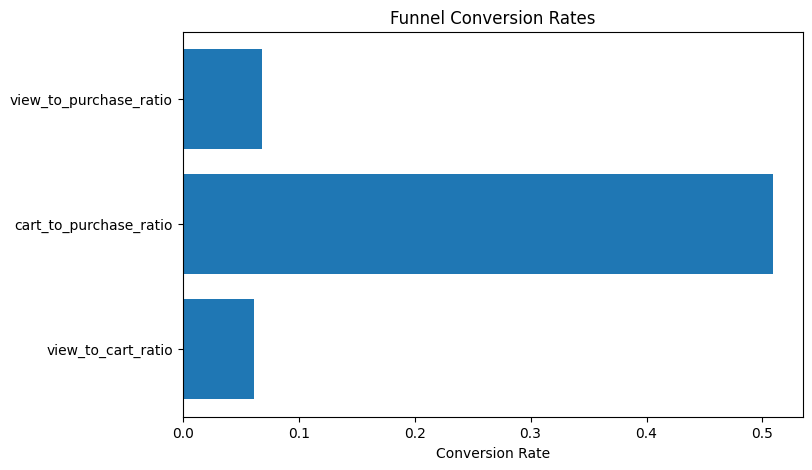

In [25]:
import matplotlib.pyplot as plt

# Funnel 데이터 준비
funnel_data = conversion_rates.iloc[0].to_dict()
funnel_stages = list(funnel_data.keys())
funnel_values = list(funnel_data.values())

# Funnel 그래프 생성
plt.figure(figsize=(8, 5))
plt.barh(funnel_stages, funnel_values)
plt.xlabel("Conversion Rate")
plt.title("Funnel Conversion Rates")
plt.show()


# 3. 월별 구매 전환율과 월별 매출 그래프

In [13]:
ex_df=df.groupBy('user_session', 'event_type').agg(count('*').alias('counts'))

f_df=ex_df.groupBy("user_session").pivot("event_type", ["view", "cart", "purchase"]).sum("counts")

In [44]:
ex_df.show()

+--------------------+----------+------+
|        user_session|event_type|counts|
+--------------------+----------+------+
|fec1fc7d-2796-43e...|      view|     4|
|b0a32a6c-a500-46d...|      view|    13|
|b5ed5e04-f69c-401...|      view|     2|
|ba24f9aa-7149-461...|      view|     2|
|aaf45a93-2f17-4c8...|      view|     1|
|38ad1e2b-60c4-457...|      view|     1|
|142fbef4-96be-46b...|      view|     3|
|a6b8206e-6607-43d...|      view|     3|
|9a9d8e0d-5c47-451...|      view|     1|
|c49a247e-0c84-4dd...|      view|     1|
|2b3a7019-4427-446...|      view|    10|
|92b9c7a9-f0c8-4b0...|      view|    40|
|2ad1195f-11fe-4f4...|      view|     1|
|d3c4d8d9-7f6b-4ef...|      view|     2|
|f0709798-afa5-4b4...|      view|     1|
|37f5c533-c006-42f...|  purchase|     1|
|ed7035cd-adbc-48a...|      cart|     1|
|3720e6a4-34fd-48c...|      view|     5|
|b02c32e4-8237-4f1...|      view|     1|
|641eb8eb-0176-49c...|      view|     1|
+--------------------+----------+------+
only showing top

In [45]:
f_df.show()

+--------------------+----+----+--------+
|        user_session|view|cart|purchase|
+--------------------+----+----+--------+
|5b8d92cb-104e-47e...|   2|NULL|    NULL|
|0757a560-1cb5-4b6...|   2|NULL|    NULL|
|f2d7d453-327c-45e...|   1|NULL|    NULL|
|eb79a40e-806f-443...|   2|NULL|    NULL|
|4532b6f5-4ed9-4cb...|   2|NULL|    NULL|
|aeaaf9ca-25b9-4d1...|   2|NULL|    NULL|
|a8485a0a-0e62-40b...|  20|NULL|    NULL|
|ccdf687f-1522-40b...|   2|NULL|    NULL|
|1558636c-1602-485...|   4|NULL|    NULL|
|0ba375f2-9170-4e8...|   1|NULL|    NULL|
|94d4f60d-79c5-41f...|   6|NULL|    NULL|
|f9436408-137c-4fc...|   8|NULL|    NULL|
|5ef32055-4acd-4b2...|   1|NULL|    NULL|
|aff0923a-f42b-4a1...|   4|NULL|    NULL|
|5c018451-82c5-495...|   1|NULL|    NULL|
|2eba879f-8481-4a8...|   2|NULL|    NULL|
|194fc2ad-6a50-4dc...|   2|   1|       1|
|28eb046f-817a-457...|   2|NULL|    NULL|
|3913088d-b43c-484...|   2|NULL|    NULL|
|06b527b9-43de-402...|   1|NULL|    NULL|
+--------------------+----+----+--

In [ ]:
df.fillna(0)

In [14]:
a_df = f_df.filter(f_df.view.isNull()).toPandas()

print(a_df)

                              user_session  view  cart  purchase
0     06ee1cbc-559c-4f9b-aa10-a6b473acdee7   NaN   2.0       NaN
1     6d585c86-897f-45c9-9682-19f4e34b43cc   NaN   1.0       NaN
2     fd1d5e0b-45ee-4930-b69d-64d9e8d5faa1   NaN   1.0       NaN
3     38795e54-9dae-492f-bc2c-abefbbb4658c   NaN   1.0       1.0
4     1e316a5c-fdbe-4734-8dcb-91563fb438dd   NaN   NaN       1.0
...                                    ...   ...   ...       ...
1764  b0a08475-b5f6-442c-a347-2e9ce5e95114   NaN   NaN       1.0
1765  aeba1a5e-3bb8-41e0-aac4-b80f417b9d4a   NaN   1.0       NaN
1766  b8693e38-c1f4-403b-a8d2-ae8b7caf3e48   NaN   NaN       1.0
1767  7d4520ed-5abf-4909-bdd5-8f29aa572951   NaN   1.0       NaN
1768  e12b9a4f-3476-44b3-88ed-420c879de959   NaN   NaN       1.0

[1769 rows x 4 columns]


In [37]:
ex_df=df.groupBy('user_session').agg(count('*').alias('counts'))

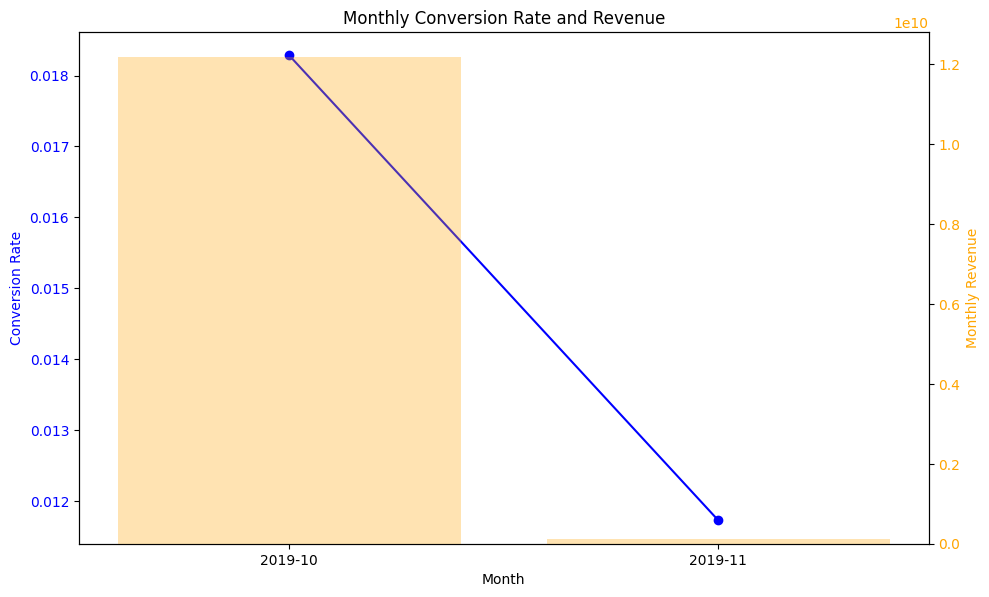

In [26]:
# 월별 구매 전환율 및 매출액 추출
monthly_conversion_revenue = spark.sql("""
    WITH monthly_data AS (
        SELECT 
            DATE_FORMAT(event_time, 'yyyy-MM') AS month,
            event_type,
            COUNT(*) AS count,
            SUM(price) AS total_revenue
        FROM ecommerce
        GROUP BY DATE_FORMAT(event_time, 'yyyy-MM'), event_type
    )
    SELECT 
        month,
        SUM(CASE WHEN event_type = 'view' THEN count ELSE 0 END) AS total_views,
        SUM(CASE WHEN event_type = 'purchase' THEN count ELSE 0 END) AS total_purchases,
        SUM(total_revenue) AS monthly_revenue
    FROM monthly_data
    GROUP BY month
    ORDER BY month
""").toPandas()

# 월별 구매 전환율 계산
monthly_conversion_revenue['conversion_rate'] = monthly_conversion_revenue['total_purchases'] / monthly_conversion_revenue['total_views']

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(10, 6))

# 월별 구매 전환율 - 꺾은선
ax1.plot(monthly_conversion_revenue['month'], monthly_conversion_revenue['conversion_rate'], marker='o', color='b', label='Conversion Rate')
ax1.set_xlabel('Month')
ax1.set_ylabel('Conversion Rate', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 월별 매출액 - 막대 그래프
ax2 = ax1.twinx()
ax2.bar(monthly_conversion_revenue['month'], monthly_conversion_revenue['monthly_revenue'], alpha=0.3, color='orange', label='Monthly Revenue')
ax2.set_ylabel('Monthly Revenue', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

fig.tight_layout()
plt.title("Monthly Conversion Rate and Revenue")
plt.show()


# 4. 코호트 분석

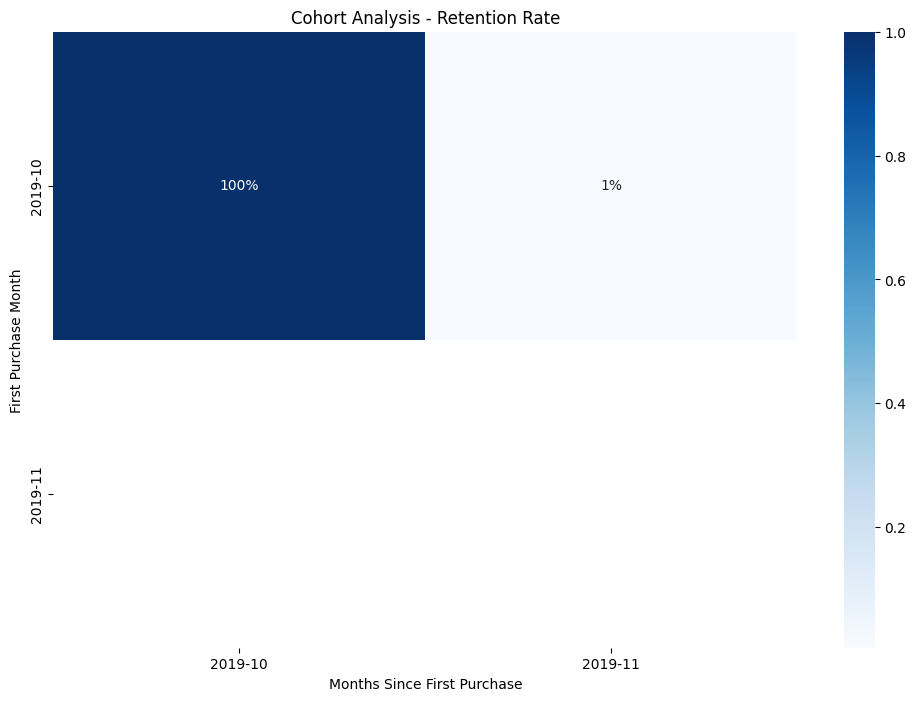

In [28]:
# 첫 구매 월 기준으로 코호트 분석 데이터 추출
cohort_data = spark.sql("""
    WITH user_first_purchase AS (
        SELECT 
            user_id,
            MIN(DATE_FORMAT(event_time, 'yyyy-MM')) AS first_purchase_month
        FROM ecommerce
        WHERE event_type = 'purchase'
        GROUP BY user_id
    ),
    user_monthly_purchase AS (
        SELECT
            u.user_id,
            u.first_purchase_month,
            DATE_FORMAT(e.event_time, 'yyyy-MM') AS purchase_month
        FROM user_first_purchase u
        JOIN ecommerce e ON u.user_id = e.user_id
        WHERE e.event_type = 'purchase'
    )
    SELECT
        first_purchase_month,
        purchase_month,
        COUNT(DISTINCT user_id) AS user_count
    FROM user_monthly_purchase
    GROUP BY first_purchase_month, purchase_month
    ORDER BY first_purchase_month, purchase_month
""").toPandas()

# 코호트 분석 결과를 피벗 테이블로 변환
cohort_pivot = cohort_data.pivot(index='first_purchase_month', columns='purchase_month', values='user_count')
cohort_pivot = cohort_pivot.div(cohort_pivot.iloc[:, 0], axis=0)

# 코호트 히트맵 시각화
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt=".0%", cmap="Blues")
plt.title("Cohort Analysis - Retention Rate")
plt.ylabel("First Purchase Month")
plt.xlabel("Months Since First Purchase")
plt.show()


In [29]:
spark.stop()